Model loaded successfully.


[*********************100%***********************]  1 of 1 completed


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


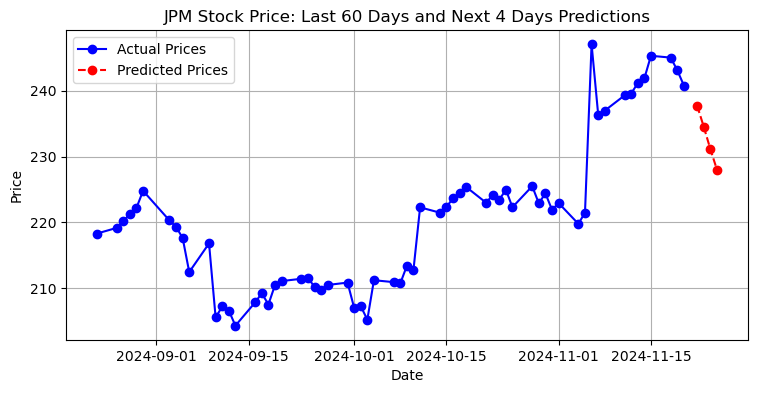

In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import timedelta
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import tkinter as tk
from tkinter import ttk, messagebox, scrolledtext
from tkcalendar import DateEntry
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

# Blue-chip stock tickers
BLUE_CHIP_STOCKS = ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'TSLA', 'FB', 'JPM', 'V', 'JNJ', 'WMT']

# Load the pre-trained model
try:
    model = load_model('finalmodel.h5')
    print("Model loaded successfully.")
except Exception as e:
    print(f"Error loading model: {str(e)}")
    model = None


def predict_stock_price(ticker, input_date):
    try:
        if model is None:
            raise Exception("The prediction model is not loaded properly.")

        input_date = pd.to_datetime(input_date)
        end_date = input_date
        start_date = input_date - timedelta(days=90)
        data = yf.download(ticker, start=start_date, end=end_date)

        if data.empty or len(data) < 60:
            return None, None, f"Not enough historical data to make predictions for {ticker}."

        closing_prices = data['Close'].values[-60:]
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_data = scaler.fit_transform(closing_prices.reshape(-1, 1))

        predicted_prices = []
        current_batch = scaled_data.reshape(1, 60, 1)

        for _ in range(4):
            next_prediction = model.predict(current_batch)
            predicted_prices.append(scaler.inverse_transform(next_prediction)[0, 0])
            current_batch = np.append(current_batch[:, 1:, :], next_prediction.reshape(1, 1, 1), axis=1)

        prediction_dates = pd.date_range(start=end_date + pd.Timedelta(days=1), periods=4)
        predictions_df = pd.DataFrame(index=prediction_dates, data=predicted_prices, columns=['Predicted Close'])

        return data, predictions_df, None
    except Exception as e:
        return None, None, f"An error occurred: {str(e)}"


def show_predictions():
    ticker = stock_var.get()
    input_date = date_entry.get()

    if not ticker or not input_date:
        messagebox.showerror("Input Error", "Please select a stock and date.")
        return

    historical_data, predictions_df, error = predict_stock_price(ticker, input_date)

    if error:
        messagebox.showerror("Prediction Error", error)
        return

    results_text.delete(1.0, tk.END)
    results_text.insert(tk.END, "Predicted Prices for the Next 4 Days:\n")
    results_text.insert(tk.END, predictions_df.to_string())

    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(historical_data.index, historical_data['Close'], label='Actual Prices', color='blue', marker='o')
    ax.plot(predictions_df.index, predictions_df['Predicted Close'], label='Predicted Prices', color='red', marker='o', linestyle='--')
    ax.set_title(f"{ticker} Stock Price: Last 60 Days and Next 4 Days Predictions")
    ax.set_xlabel("Date")
    ax.set_ylabel("Price")
    ax.legend()
    ax.grid()

    for widget in plot_frame.winfo_children():
        widget.destroy()
    canvas = FigureCanvasTkAgg(fig, master=plot_frame)
    canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)
    canvas.draw()


# GUI Setup
root = tk.Tk()
root.title("Stock Price Prediction")
root.geometry("900x750")
root.configure(bg="#f7f9fc")

# Styling
style = ttk.Style()
style.theme_use("clam")
style.configure("TLabel", font=("Arial", 12), background="#f7f9fc", foreground="#333")
style.configure("TButton", font=("Arial", 12), background="#0366fc", foreground="white")
style.configure("TCombobox", font=("Arial", 12))

# Dropdown for stock selection
ttk.Label(root, text="Select Stock:").grid(row=0, column=0, padx=10, pady=10, sticky="w")
stock_var = tk.StringVar()
stock_menu = ttk.Combobox(root, textvariable=stock_var, values=BLUE_CHIP_STOCKS, state="readonly")
stock_menu.grid(row=0, column=1, padx=10, pady=10, sticky="ew")
stock_menu.set(BLUE_CHIP_STOCKS[0])

# Date picker
ttk.Label(root, text="Select Date:").grid(row=1, column=0, padx=10, pady=10, sticky="w")
date_entry = DateEntry(root, date_pattern="yyyy-mm-dd", font=("Arial", 12))
date_entry.grid(row=1, column=1, padx=10, pady=10, sticky="ew")

# Predict button
predict_button = ttk.Button(root, text="Predict", command=show_predictions)
predict_button.grid(row=2, column=0, columnspan=2, pady=20)

# Results area
ttk.Label(root, text="Prediction Results:").grid(row=3, column=0, columnspan=2, sticky="w", padx=10)
results_text = scrolledtext.ScrolledText(root, width=60, height=10, font=("Courier", 12), wrap=tk.WORD, bg="#ffffff", fg="#333")
results_text.grid(row=4, column=0, columnspan=2, padx=10, pady=10)

# Plot frame
plot_frame = ttk.Frame(root)
plot_frame.grid(row=5, column=0, columnspan=2, pady=10, padx=10, sticky="nsew")

root.grid_rowconfigure(5, weight=1)
root.grid_columnconfigure(1, weight=1)

# Run GUI
root.mainloop()
